In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
dataset_2 ='/content/gdrive/MyDrive/Dataset_2.zip'
with ZipFile(dataset_2, 'r') as zip:
  zip.extractall()

In [4]:
data_train = pd.read_csv('/content/Dataset_2/verification_train.csv')
data_test = pd.read_csv('/content/Dataset_2/verification_test.csv')

In [5]:
data_train.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,6,2,0,0,0,0,0,0,0,2,3,7,4,4,5,5,0,0,0,0,0,0,4,5,4,5,11,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,4,9,7,8,7,5,4,8,12,5,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,0,0,0,159,161,143,180,142,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,...,255,231,241,217,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,36,50,51,68,48,48,33,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,0,60,234,215,229,223,231,107,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,224,...,0,0,0,2,0,77,210,204,156,0,0,0,0,0,0,1,76,88,35,0,0,2,5,7,3,3,3,3,7,5,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,141,45,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,238,229,227,223,255,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,220,215,210,198,185,188,194,177,189,198,203,214,166,0,0,0,0,0,0,0


In [6]:
data_test.tail(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
9990,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9991,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9992,4,0,0,0,0,0,0,0,0,0,0,0,0,131,209,206,188,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,207,198,246,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,143,149,179,189,195,199,195,172,120,0,0,1,0,0,0,0,0,0
9993,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9994,0,0,0,0,0,0,0,0,1,0,2,0,0,110,63,60,97,39,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,17,...,156,165,171,154,164,91,0,3,1,0,0,0,0,0,0,1,1,0,0,94,97,100,102,94,89,89,89,86,88,86,85,67,114,51,0,1,0,0,0,0
9995,0,0,0,0,0,0,0,0,0,0,37,93,72,58,55,63,66,89,159,120,20,0,0,0,0,1,0,0,0,0,0,0,1,0,0,22,67,125,151,168,...,112,115,117,117,113,146,41,0,3,0,0,0,0,0,0,0,1,0,1,76,54,55,51,53,53,55,53,44,38,37,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,0,0,76,36,110,170,78,136,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,...,94,84,70,44,0,36,152,65,110,0,0,0,0,0,0,0,21,57,89,7,0,0,0,0,0,0,0,0,0,0,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,0,1,3,0,14,152,184,158,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,219,223,226,239,247,241,224,213,144,0,0,0,0,0,0,1,0,44,232,199,200,190,180,179,185,189,191,185,179,178,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,131,192,79,0,0,0,0,...,13,26,17,8,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9999,1,0,0,0,0,0,0,0,140,119,103,99,102,101,104,119,118,122,130,129,127,166,128,0,0,0,0,0,0,0,0,0,0,0,0,18,211,212,212,225,...,217,206,211,217,219,216,249,222,0,0,0,0,0,0,0,0,0,0,58,94,104,109,113,105,92,53,0,65,152,120,111,95,75,44,1,0,0,0,0,0


In [7]:
X_data = data_train.drop("label", axis=1).values.astype(np.uint8)
y_data = data_train["label"].values

X_test = data_test.drop("label", axis=1).values.astype(np.uint8)
y_test = data_test["label"].values

In [8]:
class DigitsDataset(Dataset):
    def __init__(self, X, y=None, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = np.reshape(self.X[idx], (28, 28, 1))
        if self.transforms is not None:
            X = self.transforms(X)
        if self.y is not None:
            return X, self.y[idx]
        else:
            return X

In [9]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

In [10]:
train_data = DigitsDataset(X=X_data, y=y_data, transforms=transform_train)
test_data = DigitsDataset(X=X_test, y=y_test, transforms=transform_test)

## **Base Parameters**

In [11]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

6


In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:3000
Test dataloader:500


In [13]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.SELU_1 = nn.SELU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.SELU_2 = nn.SELU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.SELU_3 = nn.SELU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.SELU_4 = nn.SELU()


        ### 5th hidden layer: 100 --> 100
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.SELU_5 = nn.SELU()

        ### 6yh hidden layer: 100 --> 100
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.SELU_6 = nn.SELU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.SELU_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.SELU_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.SELU_3(out)

         ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.SELU_4(out)

        ### 5th hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 3rd hidden layer
        out = self.SELU_5(out)

        ### 6th hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 3rd hidden layer
        out = self.SELU_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [18]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (SELU_1): SELU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (SELU_2): SELU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (SELU_3): SELU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (SELU_4): SELU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (SELU_5): SELU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (SELU_6): SELU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [19]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [20]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 0.8487187623977661. Accuracy: 76.17
Iteration: 1000. Loss: 0.8520576357841492. Accuracy: 79.97
Iteration: 1500. Loss: 0.444655179977417. Accuracy: 81.74
Iteration: 2000. Loss: 0.5771995782852173. Accuracy: 81.38
Iteration: 2500. Loss: 0.7486251592636108. Accuracy: 79.59
Iteration: 3000. Loss: 0.49637365341186523. Accuracy: 84.17
Epoch:  2
Iteration: 3500. Loss: 0.7207349538803101. Accuracy: 80.63
Iteration: 4000. Loss: 0.7483327388763428. Accuracy: 83.65
Iteration: 4500. Loss: 0.20559294521808624. Accuracy: 83.82
Iteration: 5000. Loss: 0.6197263598442078. Accuracy: 83.68
Iteration: 5500. Loss: 0.6165164709091187. Accuracy: 82.57
Iteration: 6000. Loss: 0.5414336323738098. Accuracy: 84.29
Epoch:  3
Iteration: 6500. Loss: 0.5282394289970398. Accuracy: 84.86
Iteration: 7000. Loss: 0.8083437085151672. Accuracy: 84.7
Iteration: 7500. Loss: 0.09169245511293411. Accuracy: 84.99
Iteration: 8000. Loss: 0.5318252444267273. Accuracy: 84.46
Iteration: 8500. Loss: 0.5

[1.9846805334091187, 1.4201397895812988, 1.1856807470321655, 1.1254860162734985, 0.7961645126342773, 0.6280422806739807, 0.7283490300178528, 0.5611913800239563, 0.6046351790428162, 0.8132296204566956, 0.5998442769050598, 0.6485479474067688, 0.5484587550163269, 0.49890485405921936, 0.5625144839286804, 0.6283578872680664, 0.7327548861503601, 0.4530037045478821, 0.7583593130111694, 0.6850960850715637, 0.3659595847129822, 0.6663064956665039, 0.3973143696784973, 0.43785959482192993, 0.673656702041626, 0.48884761333465576, 0.524743914604187, 0.5452425479888916, 0.3899313509464264, 0.6260545253753662, 0.399155855178833, 0.6186745762825012, 0.3484938442707062, 0.6931346654891968, 0.6235641241073608, 0.30866169929504395, 0.5867230892181396]


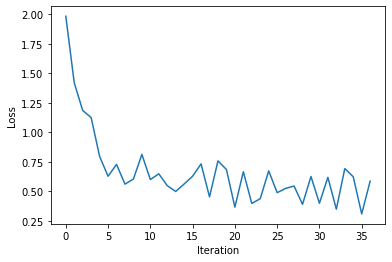

In [22]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

## **Best Parameters**

In [24]:
batch_size = 256
num_iters = 24000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

102


In [25]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 0.5611163973808289. Accuracy: 77.77
Iteration: 1000. Loss: 0.7956956624984741. Accuracy: 81.04
Iteration: 1500. Loss: 0.34406447410583496. Accuracy: 82.1
Epoch:  2
Iteration: 2000. Loss: 0.7462115287780762. Accuracy: 83.24
Iteration: 2500. Loss: 0.5585589408874512. Accuracy: 82.37
Iteration: 3000. Loss: 0.499662846326828. Accuracy: 82.93
Iteration: 3500. Loss: 0.6508123874664307. Accuracy: 84.49
Epoch:  3
Iteration: 4000. Loss: 0.24301931262016296. Accuracy: 82.02
Iteration: 4500. Loss: 0.497391015291214. Accuracy: 83.73
Iteration: 5000. Loss: 0.5011278390884399. Accuracy: 84.18
Iteration: 5500. Loss: 0.3222736418247223. Accuracy: 85.57
Epoch:  4
Iteration: 6000. Loss: 0.30190449953079224. Accuracy: 85.91
Iteration: 6500. Loss: 0.8409619927406311. Accuracy: 81.55
Iteration: 7000. Loss: 0.3216736316680908. Accuracy: 85.88
Iteration: 7500. Loss: 0.32143527269363403. Accuracy: 85.66
Epoch:  5
Iteration: 8000. Loss: 0.3068915605545044. Accuracy: 86.58
Iterat

[0.5611163973808289, 0.7956956624984741, 0.34406447410583496, 0.7462115287780762, 0.5585589408874512, 0.499662846326828, 0.6508123874664307, 0.24301931262016296, 0.497391015291214, 0.5011278390884399, 0.3222736418247223, 0.30190449953079224, 0.8409619927406311, 0.3216736316680908, 0.32143527269363403, 0.3068915605545044, 0.6285221576690674, 0.23788949847221375, 0.537895679473877, 0.43963423371315, 0.33743351697921753, 0.4245627820491791, 0.18893396854400635, 0.24733346700668335, 0.347568541765213, 0.22957536578178406, 0.18111087381839752, 0.5708153247833252, 0.22129985690116882, 0.28186848759651184, 0.25276270508766174, 0.3483419716358185, 0.24355058372020721, 0.3765985071659088, 0.35552459955215454, 0.3291385769844055, 0.3754482865333557, 0.30532804131507874, 0.19894106686115265, 0.28950008749961853, 0.20295025408267975, 0.19373950362205505, 0.4653109312057495, 0.3775189518928528, 0.22721490263938904, 0.38039082288742065, 0.3881501853466034, 0.33290624618530273, 0.38936856389045715, 0

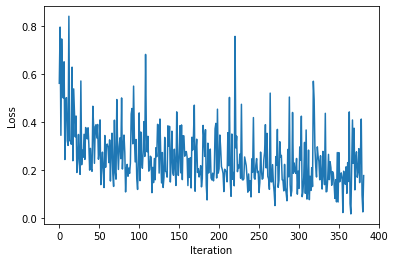

In [26]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()